# Index constituent returns

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

equities <- EquitiesIndiaNse()
indices <- Indices()

In [2]:
indexName <- "NIFTY 100"
startDate <- as.Date("2018-01-01")
endDate <- as.Date("2019-11-25")

In [3]:
constitutents <- indices$NseConstituents() %>%
        filter(NAME == indexName) %>%
        select(SYMBOL, CAP_WEIGHT) %>%
        collect() %>%
        as.data.frame()

In [4]:
constitutents$S_DATE <- NA
constitutents$E_DATE <- NA
constitutents$RETURNS_CUM <- NA
constitutents$MAX_DD <- NA

In [5]:
#nrow(constitutents)
for(i in 1:nrow(constitutents)){
    if(!is.na(constitutents$RETURNS_CUM[i])){
        next
    }
    
    sym <- toString(constitutents$SYMBOL[i])
    
    tryCatch({
        pxDf <- equities$EodAdjustedTimeSeries() %>%
            filter(SYMBOL == sym & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
            select(TIME_STAMP, CLOSE) %>%
            collect() %>%
            mutate(TIME_STAMP = as.Date(TIME_STAMP))

        pxXts <- xts(pxDf$CLOSE, pxDf$TIME_STAMP)
        dXts <- dailyReturn(pxXts)

        constitutents$RETURNS_CUM[i] <- 100*as.numeric(Return.cumulative(dXts))
        constitutents$MAX_DD[i] <- 100*as.numeric(maxDrawdown(dXts))
        constitutents$S_DATE[i] <- toString(first(index(pxXts)))
        constitutents$E_DATE[i] <- toString(last(index(pxXts)))
    }, error=function(e){
        print(sym)
        print(e)
    })
}

In [6]:
print(constitutents[order(constitutents$RETURNS_CUM, decreasing=T),])

        SYMBOL CAP_WEIGHT     S_DATE     E_DATE RETURNS_CUM   MAX_DD
11  BAJFINANCE     1.7277 2018-01-01 2019-11-25  140.842020 33.85174
38     HDFCAMC     0.2122 2018-08-06 2019-11-25  100.427261 34.65988
67   NESTLEIND     0.9101 2018-01-01 2019-11-25   89.550813 19.32652
14  BERGEPAINT     0.2107 2018-01-01 2019-11-25   84.312988 22.47438
9   BAJAJFINSV     0.9403 2018-01-01 2019-11-25   77.512503 27.38438
82    RELIANCE     8.9700 2018-01-01 2019-11-25   73.659920 21.84909
48     ICICIGI     0.3769 2018-01-01 2019-11-25   73.173836 20.26879
91         TCS     3.9699 2018-01-01 2019-11-25   66.713388 20.06814
26    DIVISLAB     0.3904 2018-01-01 2019-11-25   63.466617 17.42795
47   ICICIBANK     5.5632 2018-01-01 2019-11-25   61.531597 28.43941
58   KOTAKBANK     3.7571 2018-01-01 2019-11-25   60.541596 25.29481
92       TECHM     0.8278 2018-01-01 2019-11-25   58.569129 23.63137
44  HINDUNILVR     2.6419 2018-01-01 2019-11-25   57.462160 15.61363
28       DMART     0.3556 2018-01-

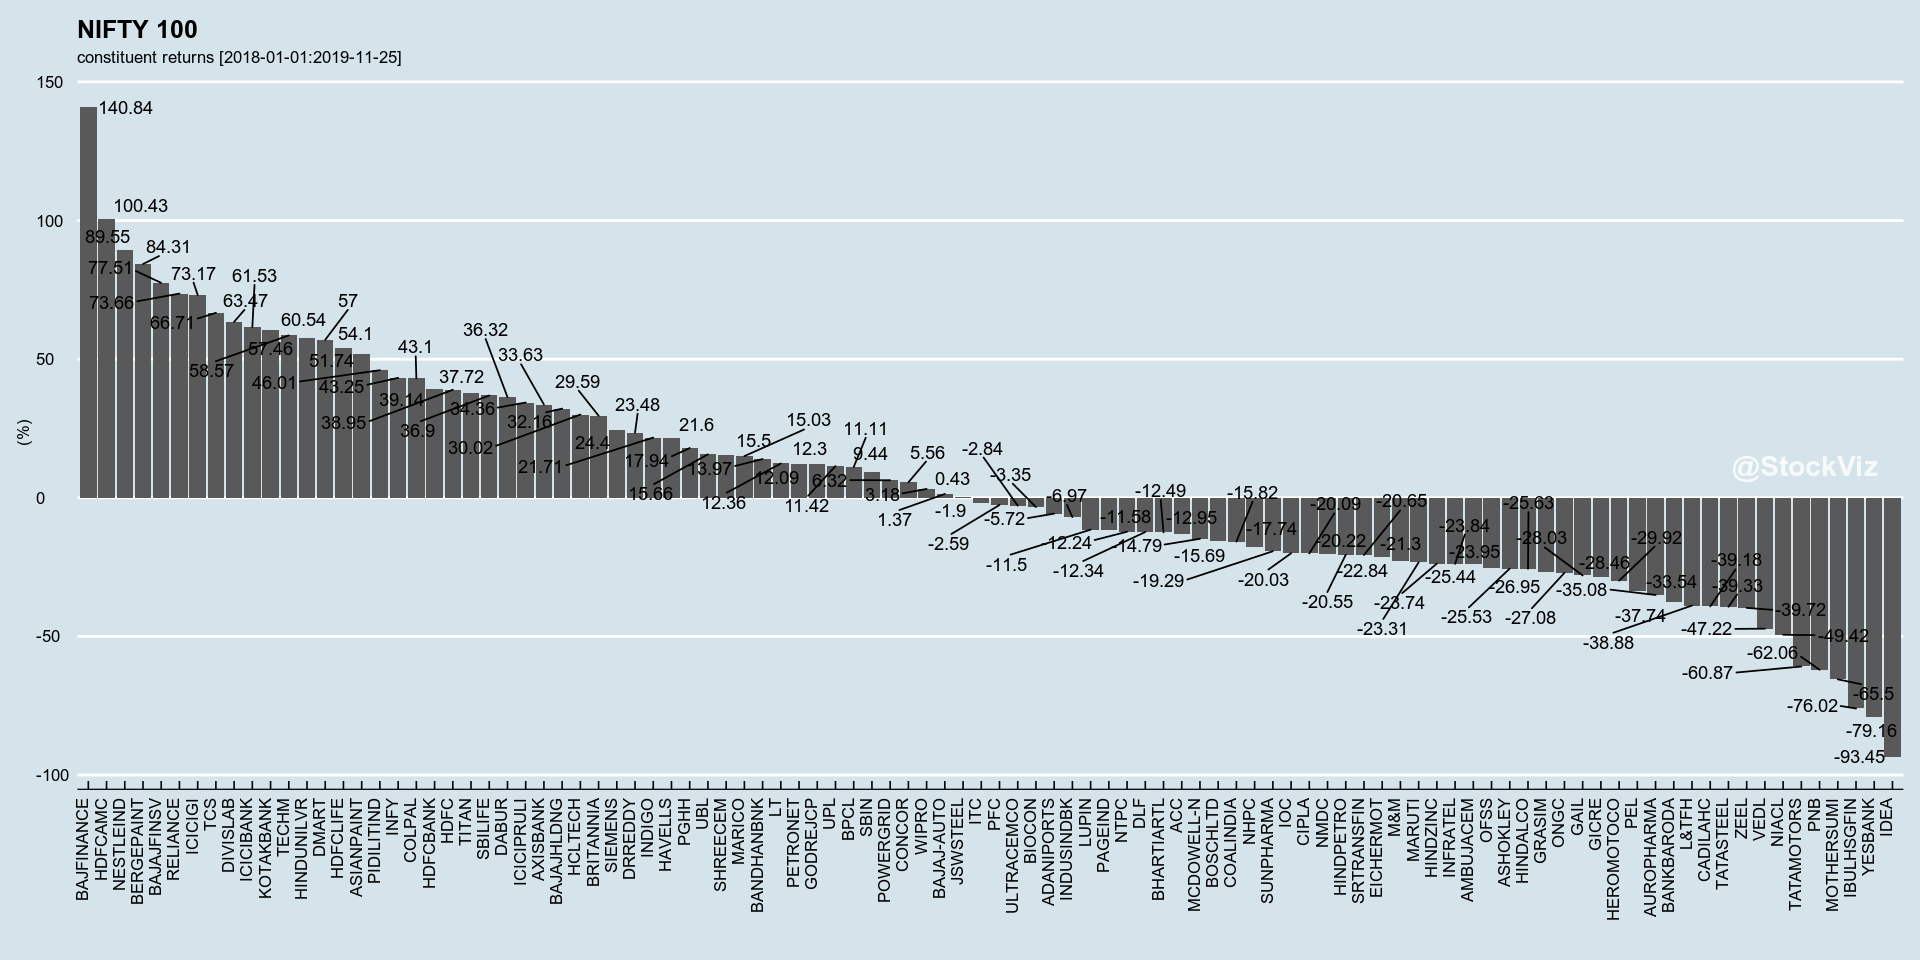

In [7]:
mDf <- constitutents[,c('SYMBOL', 'RETURNS_CUM')]
#mDf$SYMBOL <- factor(mDf$SYMBOL)

options(repr.plot.width=16, repr.plot.height=8)
ggplot(mDf, aes(x=reorder(SYMBOL, -RETURNS_CUM), y=RETURNS_CUM)) +
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_text_repel(aes(label= round(RETURNS_CUM, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=indexName, subtitle=sprintf("constituent returns [%s:%s]", startDate, endDate)) +
    annotate("text", x=nrow(mDf), y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

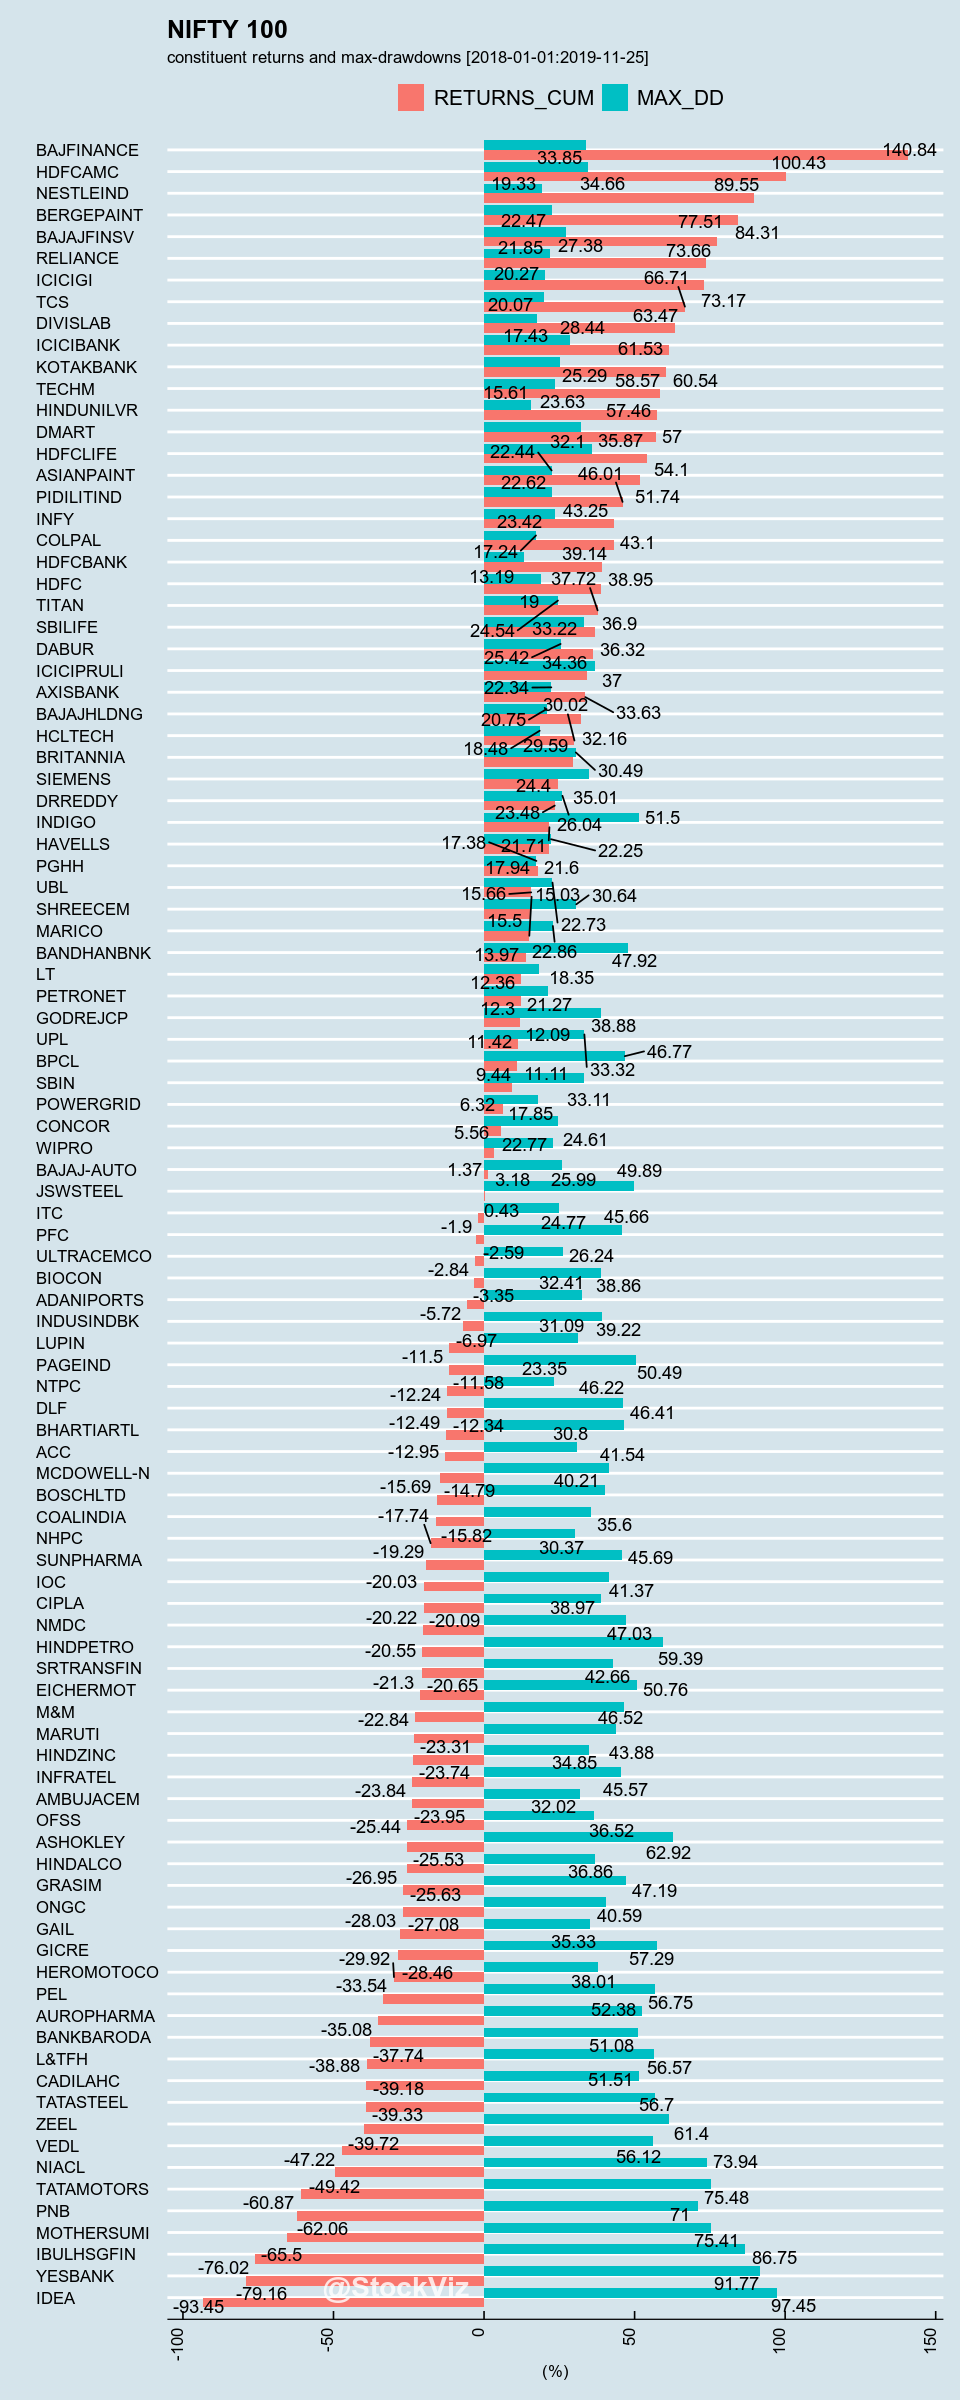

In [13]:
mDf <- constitutents[,c('SYMBOL', 'RETURNS_CUM', 'MAX_DD')]
#mDf$SYMBOL <- factor(mDf$SYMBOL)
toPlot <- melt(mDf, id='SYMBOL')
toPlot$SYMBOL <- factor(toPlot$SYMBOL, levels = toPlot$SYMBOL[order(toPlot$value[toPlot$variable == 'RETURNS_CUM'])])

options(repr.plot.width=8, repr.plot.height=20)
ggplot(toPlot, aes(x=SYMBOL, y=value, fill=variable)) +
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_text_repel(aes(label= round(value, 2)), position = position_dodge(0.9)) +
    labs(x='', y='(%)', fill='', title=indexName, subtitle=sprintf("constituent returns and max-drawdowns [%s:%s]", startDate, endDate)) +
    coord_flip() +
    annotate("text", x=0, y=0, 
             label = "@StockViz", hjust=1.1, vjust=-1.1, 
             col="white", cex=6, fontface = "bold", alpha = 0.8)  

In [46]:
iPx <- indices$NseTimeSeries() %>%
    filter(NAME == indexName & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
    select(CLOSE, TIME_STAMP) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

iPxXts <- xts(iPx$CLOSE, iPx$TIME_STAMP)
iDret <- dailyReturn(iPxXts)

In [48]:
print(100*Return.cumulative(iDret))

                  daily.returns
Cumulative Return      11.88227


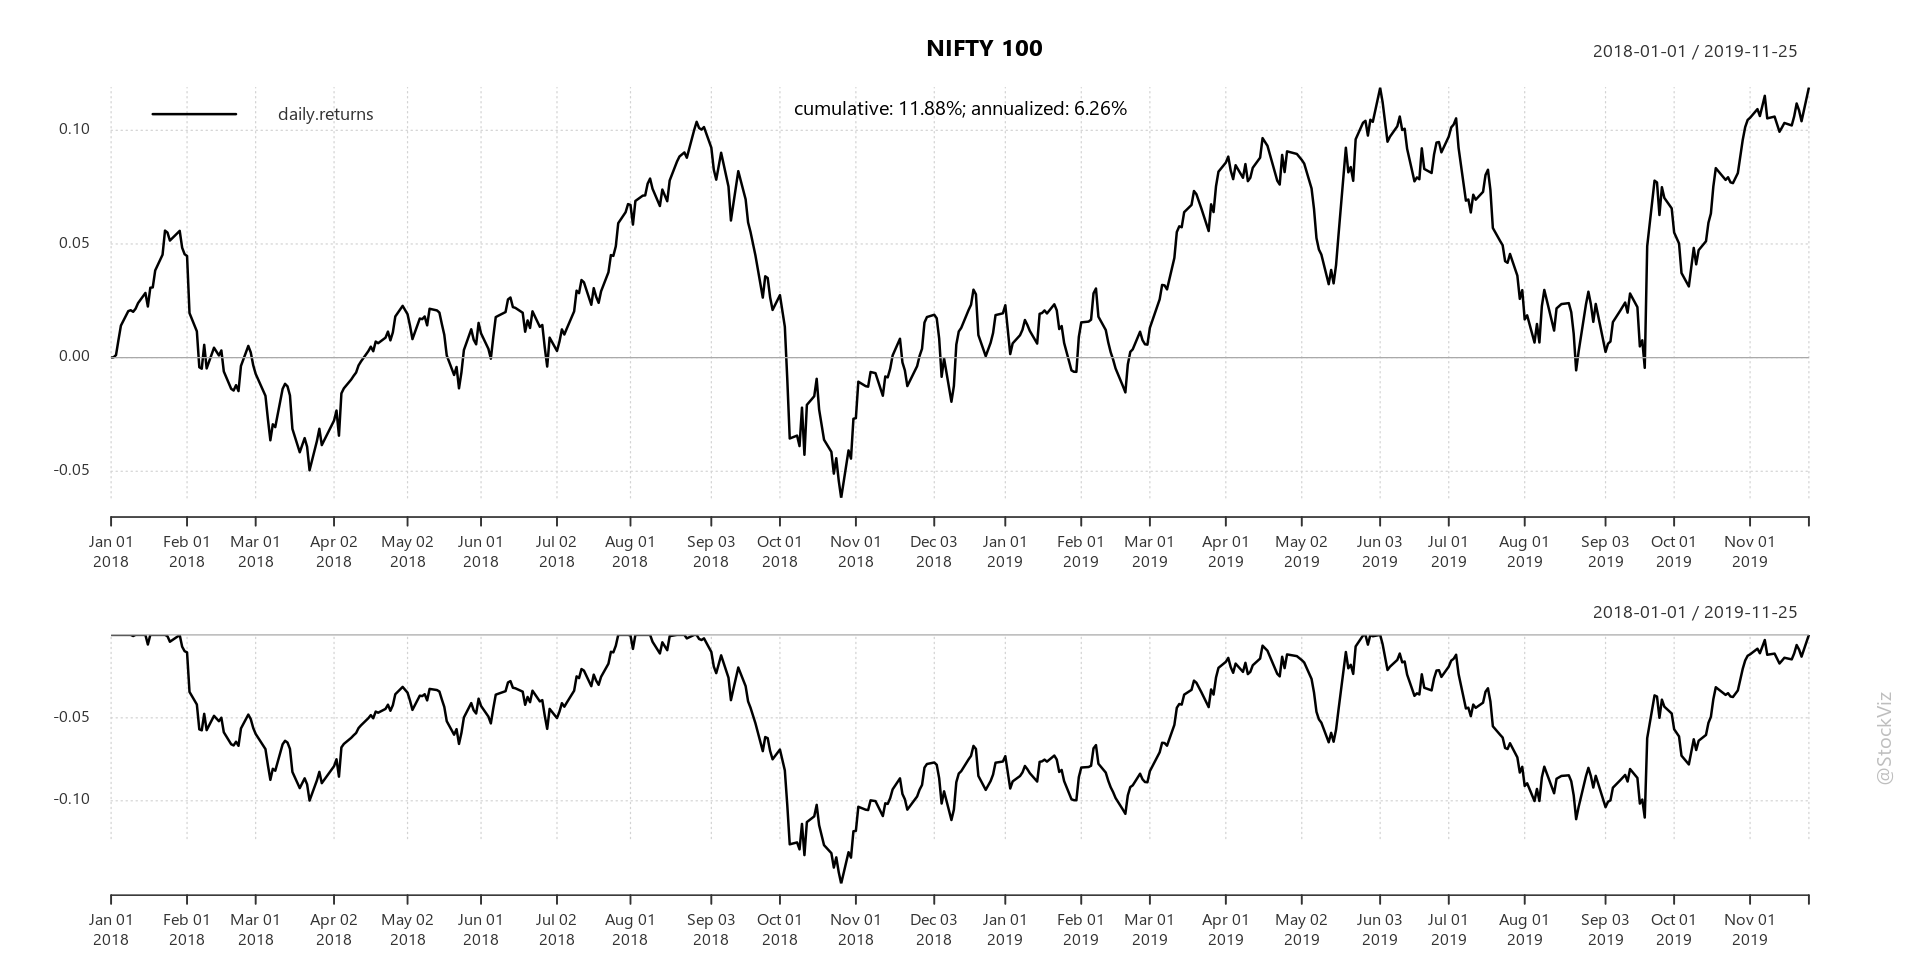

In [49]:
Common.PlotCumReturns(iDret, indexName, "")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!